# Collect RoadSide LineStrings and Crop Gardens

The roadside edge of a front garden polygon is useful to determine access to parking. For each garden polygon
- geospatial join on intersection with roadside polygon
- this should collect the line string that marks the boundary between the garden polygon and the roadside
- buffer this linestring to 9m
- use to intersect with garden polygon and reduce it, this will cut off any 'attached' rear gardens in semi/detached properties. 

I'm only interested in if parking exists, I don't care how many cars may be parked. Therefore if I just look for a driveway near the roadside edge this is sufficient, it doesn't matter if the car actually parks all the way round the back. They are assumed to gain access to off-street parking from the front of a building.

## Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

import glob

import earthpy as et 
import earthpy.spatial as es 
import earthpy.plot as ep #to plot np array of RGB pixel numbers
import cartopy as cp

import mplleaflet
import folium
import fiona
import pyproj
import contextily
import shapely as shp

import rasterio
from rasterio._base import gdal_version
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 

from rasterio.mask import mask

#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


In [2]:
from shapely.ops import linemerge

## Load lookup_rd_gdn
lookup_rd_gdn.csv is a lookup table derived in ppp06 in which each roadside garden polygon toid is linked with a residential dwelling building shape toid by the INSPIREID of the land registry land parcel that their representative points lie within. There are duplicates in this, multiple buildings and gardens associated with the same land parcel. Put this down to flats, new developments of housing estates, splitting of a single dwelling into multiple residences.

In [8]:
#drop index column and specify to read toids as strings
#they have been saved with the leading zeroes preserved, but pandas will drop leading zeroes by default
#and read in as int
lookup_rd_gdn = pd.read_csv("../data/lookup_rd_gdn.csv",
                           dtype={'INSPIREID': object, 'rd_poly_toid': object, 'gdn_poly_toid': object}
                           ).drop(['Unnamed: 0'], axis = 1) 
#forgot to not write the index column, so have to drop it

In [9]:
lookup_rd_gdn.shape

(1585, 3)

In [10]:
lookup_rd_gdn.head()

,INSPIREID,rd_poly_toid,gdn_poly_toid
0,35014222,0001000003513013,5000005125902450
1,35014259,0001000003513012,1000001778713698
2,35014286,0001000003513011,1000001778713632
3,35014325,0001000003513010,1000001778714168
4,35014359,0001000003513009,1000001778713624


## Load Topographic Area TQ1980
I created this in QGIS by selecting all the polygons in the TA layer that intersected with the TQ1980 raster layer, by drawing a square around it.

In [4]:
path = "../data/eTopoArea_1980/eTopoArea_1980.gpkg"
for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
        
ta = gpd.read_file(path)

eTopoArea_1980 7200


In [5]:
ta.shape

(7200, 23)

In [6]:
ta.TOID.nunique()
#why repeat TOIDs?

6968

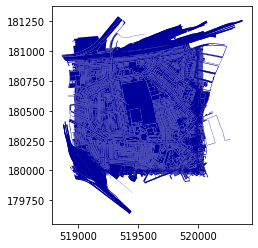

In [7]:
ta.plot(color='#00009A')

## Filter ta for residential dwellings from lookup_rd_gdn

more buildings than gardens
(so confused now)

In [11]:
rd_toid_list = lookup_rd_gdn['rd_poly_toid'].drop_duplicates().tolist()

rd = (
    ta[ta['TOID']
    .isin(rd_toid_list)]
    [['TOID', 'DescriptiveGroup', 'SHAPE_Length', 'SHAPE_Area', 'geometry']]
    .drop_duplicates()
    .reset_index(drop = True)
)

In [12]:
rd.shape

(1322, 5)

In [13]:
rd.head()

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,geometry
0,1000001778783957,Building,75.707951,287.886050,"POLYGON ((519663.510 180013.930, 519664.570 18..."
1,0001000003512201,Building,30.767529,54.315525,"POLYGON ((519692.850 180003.600, 519699.300 18..."
2,0001000003512728,Building,43.345292,88.008750,"POLYGON ((519588.000 179999.750, 519585.000 17..."
3,0001000003512749,Building,40.155576,68.345000,"POLYGON ((519583.700 180009.150, 519590.900 18..."
4,0001000003512748,Building,96.268190,401.020250,"POLYGON ((519889.800 179996.150, 519888.150 18..."


## Filter ta for residential garden polygons from lookup_rd_gdn

In [14]:
#remove duplicates and create list of garden toids
gdn_toid_list = lookup_rd_gdn['gdn_poly_toid'].drop_duplicates().tolist()
#filter ta for these toids
#select only required cols and deduplicate
gdn = (
    ta[ta['TOID']
    .isin(gdn_toid_list)]
    [['TOID', 'DescriptiveGroup', 'SHAPE_Length', 'SHAPE_Area', 'geometry']]
    .drop_duplicates()
    .reset_index(drop = True)
)

In [15]:
gdn.shape

(1437, 5)

In [16]:
gdn.TOID.nunique()

1437

In [17]:
gdn.head()

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,geometry
0,1000001778783950,General Surface,448.361385,696.324061,"POLYGON ((519657.544 180045.614, 519659.195 18..."
1,1000001778708314,General Surface,25.102976,18.536250,"POLYGON ((519787.350 180008.450, 519790.150 18..."
2,1000001778708000,General Surface,75.725109,100.950737,"POLYGON ((519573.550 179999.850, 519577.200 17..."
3,1000001778708002,General Surface,16.324930,15.126250,"POLYGON ((519590.900 180004.300, 519593.300 18..."
4,1000001778708315,General Surface,15.427639,13.905000,"POLYGON ((519790.150 180001.300, 519794.750 18..."


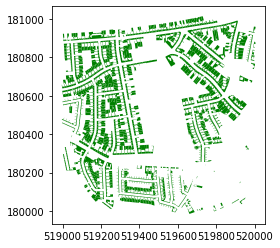

In [17]:
gdn.plot(color='green')
#these are residential, roadside gardens

## Filter ta for roadside polygons

This shows the solid coloured pavements, roadside polygons, in grey.

In [18]:
#create gdf of roadside objects ta_rs (topographic area roadside)
#select only required cols and deduplicate
ta_rs = (
    ta.query('DescriptiveGroup == "Roadside"')
    [['TOID', 'DescriptiveGroup', 'SHAPE_Length', 'SHAPE_Area', 'geometry']]
    .drop_duplicates()
    .reset_index(drop = True)
)

In [19]:
ta_rs.shape

(177, 5)

In [20]:
ta_rs.TOID.nunique()

177

In [21]:
ta_rs.sort_values(by='TOID').head()

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,geometry
151,1000001778258725,Roadside,1059.140943,1558.651702,"POLYGON ((520159.750 181051.100, 520176.300 18..."
148,1000001778262848,Roadside,600.988820,1157.834095,"POLYGON ((519267.561 181007.684, 519266.147 18..."
147,1000001778263239,Roadside,6.092295,2.375200,"POLYGON ((519273.760 181021.410, 519273.400 18..."
32,1000001778685511,Roadside,936.522971,1139.107395,"POLYGON ((519086.550 180570.300, 519086.900 18..."
31,1000001778685513,Roadside,989.894363,1428.022245,"POLYGON ((519097.500 180582.150, 519097.750 18..."


(180500, 181000)

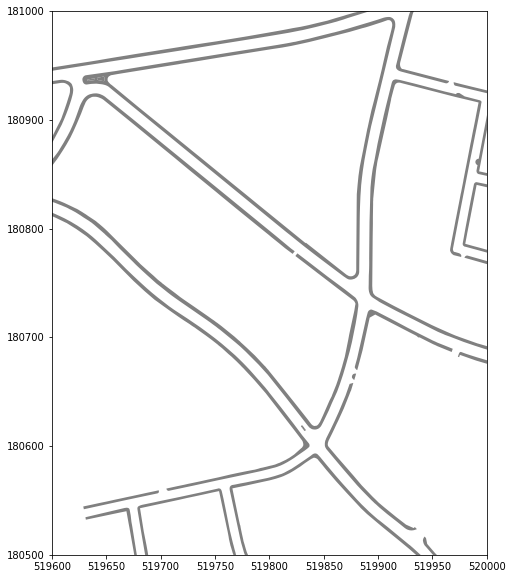

In [22]:
base = ta_rs.plot(figsize = (10,10), color = 'grey')
base.set_xlim(xmin = 519600, xmax = 520000)
base.set_ylim(ymin = 180500, ymax = 181000)

## Intersect each gdn polygon with ta_rs polygon

- join ta_rs and gdn
- drop gdn polygons that intersect with more than one ta_rs polygon

Other options might be to dissolve the n roadside polygons into one, but this would create multipolygon sets later on where the garden intersects with roadside in more than mone disjoint place. Could then exlpode these multi-geomoetries. But then I would have more than one roadside edge for a garden, one of which may actually attach to the rear garden.

In [23]:
#Spatial join; inner; intersects
#keep LHS gdf geometries that intersect with RHS geometries
#keep RHS information too, but not the geometries, so rows may increase
join_rs = ( gpd.sjoin(ta_rs[['TOID', 'geometry']]
                    , gdn[['TOID', 'geometry']]
                    , how = 'inner'
                    , op = 'intersects')
           .drop(['index_right'], axis = 'columns')
           .rename({'TOID_left':'rsTOID', 'geometry':'rsGeometry', 'TOID_right':'gdnTOID'}, axis='columns')
           .reset_index(drop=True)
          )
#TOID_left: roadside TOID, geometry: ta_rs geometry, TOID_right: gdn TOID
#set geometry
join_rs = join_rs.set_geometry('rsGeometry')

The roadside polygons are much bigger than the garden polygons. As such one roadside polygon will appear in multiple rows and so be plotted over itself multiple times, hence darker shading.

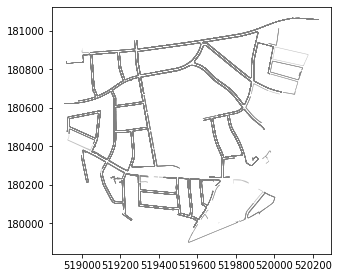

In [24]:
join_rs.plot(figsize=(5,5), color = 'grey', alpha = 0.5)

In [25]:
join_rs.head()


,rsTOID,rsGeometry,gdnTOID
0,1000001778708368,"POLYGON ((519812.541 180008.395, 519811.356 18...",1000001778708315
1,1000001778708368,"POLYGON ((519812.541 180008.395, 519811.356 18...",1000001778708317
2,1000001778708368,"POLYGON ((519812.541 180008.395, 519811.356 18...",1000001778708314
3,1000001778708368,"POLYGON ((519812.541 180008.395, 519811.356 18...",1000001778708617
4,1000001778708235,"POLYGON ((519294.548 180215.142, 519294.658 18...",1000001778708002


In [26]:
join_rs.rsGeometry.geom_type.unique()

array(['Polygon'], dtype=object)

In [27]:
join_rs.shape

(1444, 3)

In [28]:
join_rs.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [29]:
#there are 1437 garden TOIDs, so I have 7 duplicates, find them
v = join_rs.gdnTOID.value_counts() #create value counts of specified column values
join_rs[join_rs.gdnTOID.isin(v.index[v.gt(1)])] #use v to subset for greater than (gt) n. (less than: lt)

,rsTOID,rsGeometry,gdnTOID
96,1000001778708646,"POLYGON ((519659.950 180067.800, 519659.200 18...",1000001778783950
97,1000001778783951,"POLYGON ((519654.550 180022.140, 519652.298 18...",1000001778783950
663,1000001778702272,"POLYGON ((519037.700 180887.050, 519037.550 18...",1000001778702160
664,1000001778685695,"POLYGON ((519002.120 180884.870, 519002.030 18...",1000001778702160
1135,1000001778713505,"POLYGON ((519101.000 180276.950, 519101.750 18...",1000001778713495
1136,1000001778713498,"POLYGON ((519099.950 180274.300, 519101.550 18...",1000001778713495
1169,1000001778931377,"POLYGON ((519406.080 180236.890, 519400.520 18...",1000001778797006
1170,1000001778713831,"POLYGON ((519373.810 180239.270, 519373.750 18...",1000001778797006
1260,5000005125902558,"POLYGON ((519223.300 180263.800, 519223.400 18...",1000001778714251
1261,1000001778713963,"POLYGON ((519137.208 180312.406, 519135.150 18...",1000001778714251


### Gardens with more than one roadside polygon
 Three garden polygons shown in shades of green below, that all intersect with the two roadside polygons shown in grey and black.

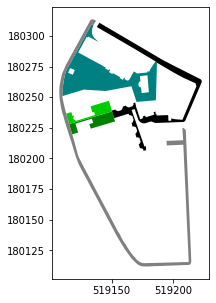

In [30]:
base = gdn.query("TOID == '1000001778714251'").plot(figsize=(5,5),color='green')
gdn.query("TOID == '1000001778714252'").plot(ax = base, color='#00CC00')
gdn.query("TOID == '1000001778842952'").plot(ax = base, color='#008080')
ta_rs.query("TOID == '5000005125902558'").plot(ax = base, color='black')
ta_rs.query("TOID == '1000001778713963'").plot(ax = base, color='grey')
#so these are instances of a single garden TOID touching more than one roadside TOID
#DISSOLVE these roadside polys into one? maybe - drop for now
#the top garen here is uspect - looks like a block of flats surrounded by shared garden

## Drop gardens that intersect more than one  roadside polygon

See standard operations as functions for more on .gt, .lt, .eq etc
https://docs.python.org/2/library/operator.html

Need to drop these gardens from the roadside gdf and from the garden gdf!!!

In [31]:
join_rs = join_rs[join_rs.gdnTOID.isin(v.index[v.eq(1)])]

In [32]:
join_rs.nunique()

rsTOID          59
rsGeometry      59
gdnTOID       1430
dtype: int64

In [33]:
join_rs.sort_values(by='gdnTOID')

,rsTOID,rsGeometry,gdnTOID
1088,1000001778713982,"POLYGON ((519323.400 180248.200, 519339.400 18...",0001000003513170
1385,5000005138038448,"POLYGON ((520096.900 181064.550, 520097.100 18...",1000001778258479
1381,5000005138038448,"POLYGON ((520096.900 181064.550, 520097.100 18...",1000001778258579
1389,5000005138038448,"POLYGON ((520096.900 181064.550, 520097.100 18...",1000001778258580
1393,5000005138038448,"POLYGON ((520096.900 181064.550, 520097.100 18...",1000001778258608
...,...,...,...
475,1000001778697462,"POLYGON ((519695.250 180239.450, 519708.400 18...",5000005254709508
407,1000001778697931,"POLYGON ((519756.100 180558.800, 519756.250 18...",5000005254709530
976,1000001778697742,"POLYGON ((519647.700 180922.100, 519649.000 18...",5000005254709546
958,1000001778697742,"POLYGON ((519647.700 180922.100, 519649.000 18...",5000005254709547


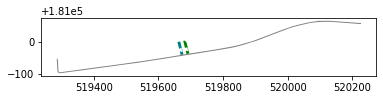

In [34]:
base = gdn.query("TOID == '1000001778258479'").plot(color='green')
gdn.query("TOID == '1000001778258579'").plot(ax = base, color='#008080')
ta_rs.query("TOID == '5000005138038448'").plot(ax = base, color='grey')

In [35]:
#create list of simple garden toids - gardens that intersect with only 1 roadside
simple_gdn_list = join_rs['gdnTOID'].drop_duplicates().tolist()

gdn = (
    gdn[gdn['TOID']
    .isin(simple_gdn_list)]
    .drop_duplicates()
    .reset_index(drop = True)
)

In [36]:
gdn.head()

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,geometry
0,1000001778708314,General Surface,25.102976,18.536250,"POLYGON ((519787.350 180008.450, 519790.150 18..."
1,1000001778708000,General Surface,75.725109,100.950737,"POLYGON ((519573.550 179999.850, 519577.200 17..."
2,1000001778708002,General Surface,16.324930,15.126250,"POLYGON ((519590.900 180004.300, 519593.300 18..."
3,1000001778708315,General Surface,15.427639,13.905000,"POLYGON ((519790.150 180001.300, 519794.750 18..."
4,1000001778707992,General Surface,70.551103,116.658750,"POLYGON ((519715.400 180002.650, 519714.950 18..."


In [37]:
gdn.shape
#lost 7 problem gardens

(1430, 5)

### Deduplicate join_rs to get rs gdf of unique roadside polygons

Each of which intersects with at least one garden polygon from gdn

In [38]:
rs = (join_rs.copy(deep = True)
      .drop(['gdnTOID'], axis = 1)
      .drop_duplicates()
      .reset_index(drop = True)     
     )

In [39]:
rs.shape

(59, 2)

In [40]:
join_rs.rsTOID.nunique() == rs.shape[0] #59

True

## Collect roadside linestrings per garden

Just need the gdf of unique roadside polygons that intersect with gardens (59), and the gdf of unique garden polygons that intersect with roadside polygons (1430).

In [41]:
rsEdge = gpd.overlay(gdn, rs, how = 'intersection', keep_geom_type=False)

In [42]:
rsEdge.shape

(1430, 6)

In [43]:
# Return unique geometry types
rsEdge['geometry'].geom_type.unique()
#crap I have points as well!

array(['LineString', 'MultiLineString', 'MultiPoint', 'Point'],
      dtype=object)

In [44]:
rsEdge['geometry'].geom_type.value_counts()

LineString         1022
MultiLineString     406
MultiPoint            1
Point                 1
dtype: int64

In [45]:
rsEdge.head()

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,rsTOID,geometry
0,1000001778708314,General Surface,25.102976,18.536250,1000001778708368,"LINESTRING (519791.500 179998.700, 519790.100 ..."
1,1000001778708315,General Surface,15.427639,13.905000,1000001778708368,"MULTILINESTRING ((519795.850 180000.450, 51979..."
2,1000001778708617,General Surface,66.041082,88.202500,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ..."
3,1000001778708317,General Surface,18.042444,17.585000,1000001778708368,"MULTILINESTRING ((519800.450 180005.450, 51980..."
4,1000001778708000,General Surface,75.725109,100.950737,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ..."


In [44]:
#write rsEdge to txt file to look at geometry in detail
#rsEdge.to_csv("../data/rsEdge.csv", index=False)

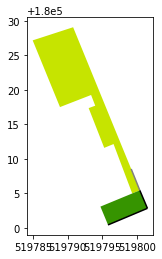

In [46]:
base = rsEdge.query("index == 2").plot(color = 'grey')
gdn.query("TOID == '1000001778708617'").plot(ax = base, color = '#C6E400')

rsEdge.query("index == 3").plot(ax = base, color = 'black')
gdn.query("TOID == '1000001778708317'").plot(ax = base, color = '#369400')

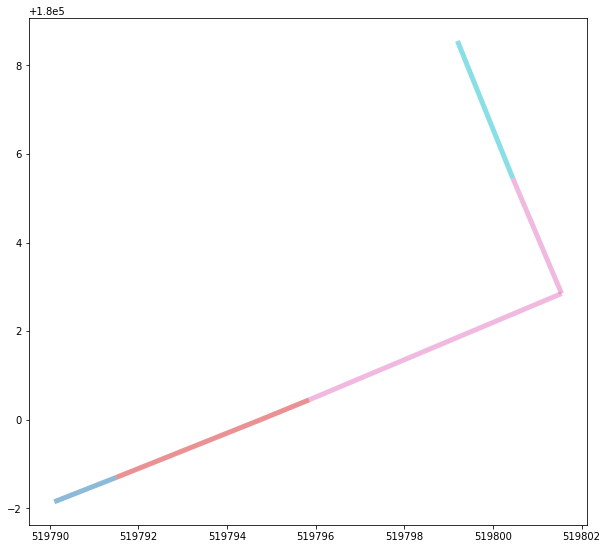

In [47]:
rsEdge.query("index < 4").plot(figsize = (10,10), column = 'TOID', alpha = 0.5, linewidth = 5)

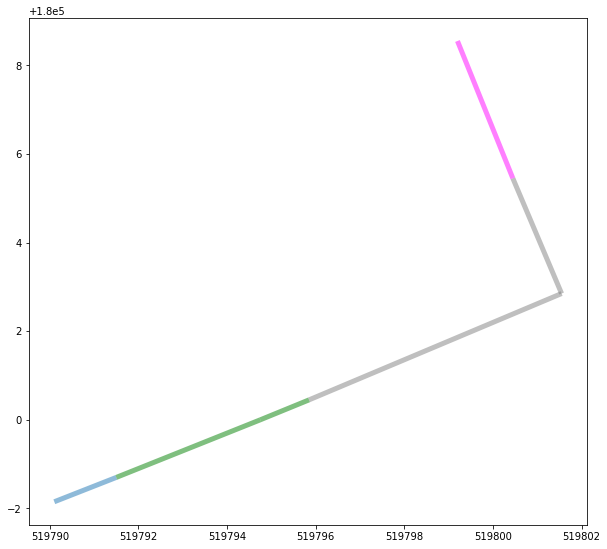

In [48]:
base = rsEdge.query("index == 0").plot(figsize = (10,10), linewidth = 5, alpha = 0.5)
rsEdge.query("index == 1").plot(ax = base, color = 'green', linewidth = 5, alpha = 0.5)
rsEdge.query("index == 2").plot(ax = base, color = 'magenta', linewidth = 5, alpha = 0.5)
rsEdge.query("index == 3").plot(ax = base, color = 'grey', linewidth = 5, alpha = 0.5)

### Not just LineStrings

MultiLineStrings seem to mostly be pieces going round corners, which is somewhat expected, although there are instances of MultiLineStrings that are apparently a contiguous LineString (???). Don't understand how this has happend.


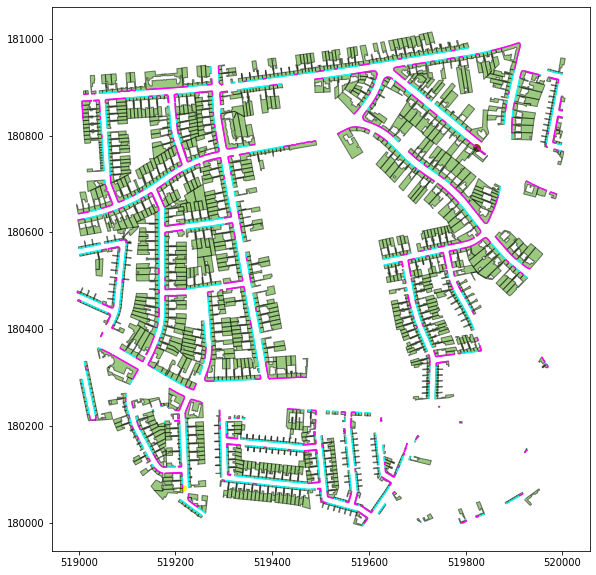

In [52]:
#MultiLineString edges in magenta
base = (   rsEdge[rsEdge['geometry'].geom_type == 'MultiLineString']
    .reset_index(drop = True)
    .plot(figsize = (10,10), color = 'magenta'))
#LineSting edges in cyan
(   rsEdge[rsEdge['geometry'].geom_type == 'LineString']
    .reset_index(drop = True)
    .plot(ax = base, color = 'cyan'))
#a Point in yellow
(   rsEdge[rsEdge['geometry'].geom_type == 'Point']
    .reset_index(drop = True)
    .plot(ax = base, color = 'yellow'))
#a MultiPoint in brown
(   rsEdge[rsEdge['geometry'].geom_type == 'MultiPoint']
    .reset_index(drop = True)
    .plot(ax = base, color = 'brown'))
#gardens in green with black edges
gdn.plot(ax = base, color = '#369400', alpha = 0.5, edgecolor = 'black')

#base.set_xlim(xmin = 519600, xmax = 519900)
#base.set_ylim(ymin = 180600, ymax = 180900)

## Merge MultiLineStrings to LineStrings & drop any remaining
https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.linemerge
shp.ops.linemerge()

In [53]:
#create rs_ls: roaside_linestrings
#drop the multi/point geometries
rs_ls = rsEdge.copy(deep = True)[ ~rsEdge['geometry'].geom_type.isin(['Point', 'MultiPoint']) ]

#use lambda to apply a function to each row of a gdf
rs_ls['geometry'] = ( 
    rs_ls['geometry'].apply(lambda x: linemerge(x) if x.geom_type == 'MultiLineString' else x)
)


In [54]:
rs_ls['geometry'].geom_type.value_counts()

LineString         1413
MultiLineString      15
dtype: int64

This is much better, still some extra multilinestrings though

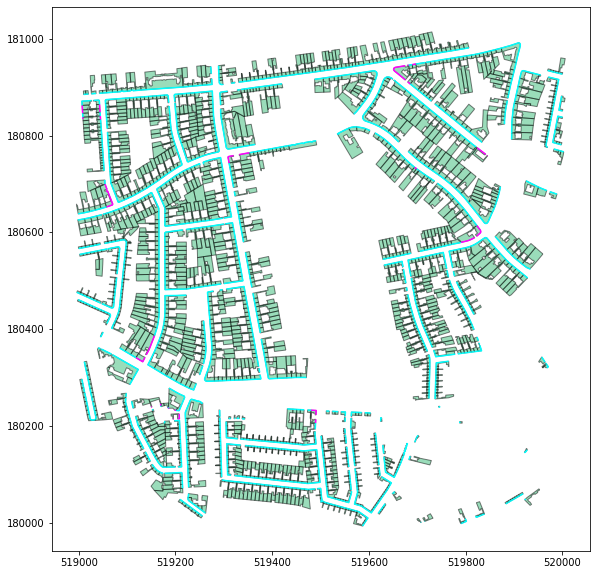

In [55]:
#MultiLineString edges in magenta
base = (   rs_ls[rs_ls['geometry'].geom_type == 'MultiLineString']
    .reset_index(drop = True)
    .plot(figsize = (10,10), color = 'magenta'))
#LineSting edges in cyan
(   rs_ls[rs_ls['geometry'].geom_type == 'LineString']
    .reset_index(drop = True)
    .plot(ax = base, color = 'cyan'))

#gardens in green with black edges
gdn.plot(ax = base, color = '#36BB77', alpha = 0.5, edgecolor = 'black')

#base.set_xlim(xmin = 519600, xmax = 519900)
#base.set_ylim(ymin = 180600, ymax = 180900)

## Add buffer to see extent of LineStrings

In [56]:
rs_ls.columns

Index(['TOID', 'DescriptiveGroup', 'SHAPE_Length', 'SHAPE_Area', 'rsTOID',
       'geometry'],
      dtype='object')

In [57]:
#set geometry to non-buffer
#buffer agruments: https://shapely.readthedocs.io/en/latest/manual.html#shapely.geometry.CAP_STYLE
#cap_style 2: flat ends on a shape that has ends (1=round, 3=square)
#join_type 3: bevelled
rs_ls = rs_ls.set_geometry('geometry')
rs_ls['rsBuffGeometry'] = rs_ls.geometry.buffer(distance = 3, cap_style = 2, join_style = 3)

In [58]:
#set geometry to buffer
rs_ls = rs_ls.set_geometry('rsBuffGeometry')

In [59]:
rs_ls['rsBuffGeometry'].geom_type.value_counts()

Polygon         1414
MultiPolygon      14
dtype: int64

(180400, 180800)

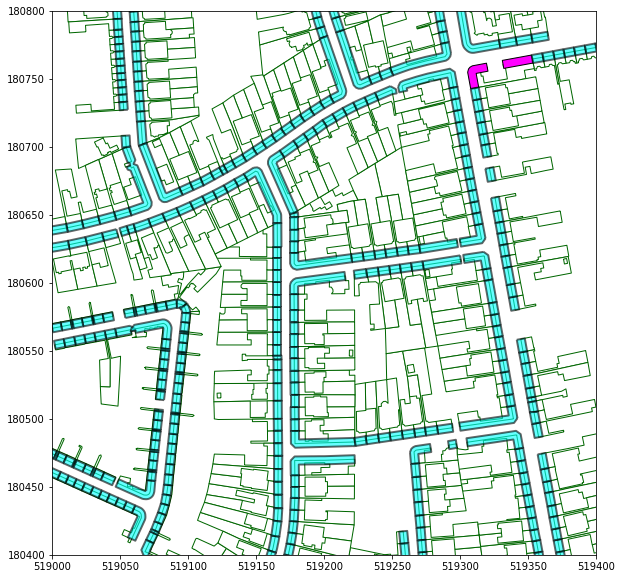

In [60]:
#set geometry to buffer
rs_ls = rs_ls.set_geometry('rsBuffGeometry')

#garden edges
base = gdn.plot(figsize = (10,10), color = 'white', edgecolor = '#006600')

#MultiLineString edges in magenta
(   rs_ls[rs_ls['rsBuffGeometry'].geom_type == 'MultiPolygon']
    .reset_index(drop = True)
    .plot(ax = base, color = 'magenta', edgecolor = 'black'))
#LineSting edges in cyan
(   rs_ls[rs_ls['rsBuffGeometry'].geom_type == 'Polygon']
    .reset_index(drop = True)
    .plot(ax = base, color = 'cyan', alpha = 0.6, edgecolor = 'black', linewidth = 2))

base.set_xlim(xmin = 519000, xmax = 519400)
base.set_ylim(ymin = 180400, ymax = 180800)

In [61]:
rs_ls

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,rsTOID,geometry,rsBuffGeometry
0,1000001778708314,General Surface,25.102976,18.536250,1000001778708368,"LINESTRING (519791.500 179998.700, 519790.100 ...","POLYGON ((519791.197 179995.358, 519789.003 18..."
1,1000001778708315,General Surface,15.427639,13.905000,1000001778708368,"LINESTRING (519795.850 180000.450, 519794.750 ...","POLYGON ((519795.886 179997.223, 519795.864 17..."
2,1000001778708617,General Surface,66.041082,88.202500,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ...","POLYGON ((519803.232 180006.572, 519797.668 18..."
3,1000001778708317,General Surface,18.042444,17.585000,1000001778708368,"LINESTRING (519800.450 180005.450, 519801.550 ...","POLYGON ((519800.454 180005.452, 519803.213 18..."
4,1000001778708000,General Surface,75.725109,100.950737,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ...","POLYGON ((519589.432 179991.341, 519584.368 17..."
...,...,...,...,...,...,...,...
1425,1000001778708052,General Surface,16.299354,14.745000,1000001778783951,"LINESTRING (519625.700 180028.100, 519628.850 ...","POLYGON ((519626.411 180034.246, 519631.289 18..."
1426,1000001778708051,General Surface,16.894646,16.040000,1000001778783951,"LINESTRING (519619.250 180019.150, 519622.500 ...","POLYGON ((519620.059 180025.444, 519624.941 18..."
1427,1000001778708048,General Surface,16.426828,15.160000,1000001778783951,"LINESTRING (519622.500 180023.700, 519625.700 ...","POLYGON ((519623.274 180029.865, 519628.126 18..."
1428,1000001778713497,General Surface,64.595658,105.822500,1000001778713498,"LINESTRING (519098.500 180267.550, 519097.750 ...","POLYGON ((519100.735 180259.751, 519094.765 18..."


### Drop remaining MultiLineStrings

I think this will drop the troublesome properties at this time.


In [62]:
rs_ls.geometry.name

'rsBuffGeometry'

In [63]:
rs_ls.columns
#geometry is the line geometry
#rsBuffGeometry is the buffered line, with flat ends
#TOID is the garden toid that this edge goes with?

Index(['TOID', 'DescriptiveGroup', 'SHAPE_Length', 'SHAPE_Area', 'rsTOID',
       'geometry', 'rsBuffGeometry'],
      dtype='object')

In [64]:
#set geometry
rs_ls = rs_ls.set_geometry('geometry')
rs_ls = rs_ls[ rs_ls['geometry'].geom_type.isin(['LineString']) ]

In [66]:
rs_ls.shape

(1413, 7)

In [65]:
rs_ls.head()
#1413 rows

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,rsTOID,geometry,rsBuffGeometry
0,1000001778708314,General Surface,25.102976,18.536250,1000001778708368,"LINESTRING (519791.500 179998.700, 519790.100 ...","POLYGON ((519791.197 179995.358, 519789.003 18..."
1,1000001778708315,General Surface,15.427639,13.905000,1000001778708368,"LINESTRING (519795.850 180000.450, 519794.750 ...","POLYGON ((519795.886 179997.223, 519795.864 17..."
2,1000001778708617,General Surface,66.041082,88.202500,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ...","POLYGON ((519803.232 180006.572, 519797.668 18..."
3,1000001778708317,General Surface,18.042444,17.585000,1000001778708368,"LINESTRING (519800.450 180005.450, 519801.550 ...","POLYGON ((519800.454 180005.452, 519803.213 18..."
4,1000001778708000,General Surface,75.725109,100.950737,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ...","POLYGON ((519589.432 179991.341, 519584.368 17..."


In [67]:
rs_ls.nunique()
#perfect

TOID                1413
DescriptiveGroup       1
SHAPE_Length        1413
SHAPE_Area          1413
rsTOID                59
geometry            1413
rsBuffGeometry      1413
dtype: int64

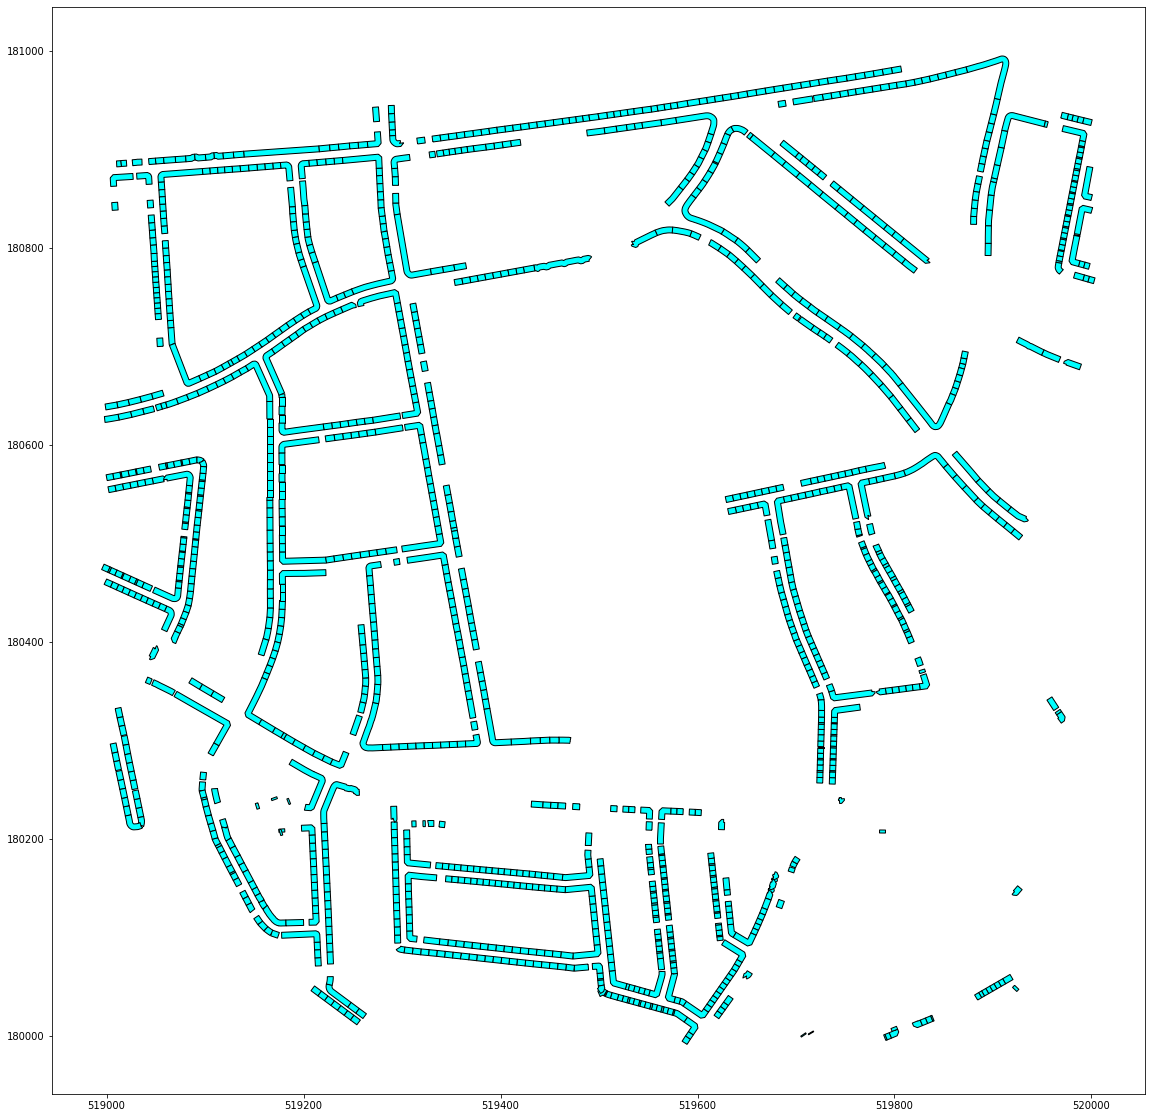

In [68]:
#set geom
rs_ls = rs_ls.set_geometry('rsBuffGeometry')

rs_ls.plot(figsize = (20,20), color = 'cyan', edgecolor = 'black')

## Add column of length of roadside edge

Want this so I can drop any roadside LineStrings that are silly short


In [69]:
#set geometry to LineString geom (geometry) first
rs_ls = rs_ls.set_geometry('geometry')
rs_ls['LineString_length'] = ( 
    rs_ls['geometry'].length
)


In [70]:
rs_ls.head()

,TOID,DescriptiveGroup,SHAPE_Length,SHAPE_Area,rsTOID,geometry,rsBuffGeometry,LineString_length
0,1000001778708314,General Surface,25.102976,18.536250,1000001778708368,"LINESTRING (519791.500 179998.700, 519790.100 ...","POLYGON ((519791.197 179995.358, 519789.003 18...",1.504161
1,1000001778708315,General Surface,15.427639,13.905000,1000001778708368,"LINESTRING (519795.850 180000.450, 519794.750 ...","POLYGON ((519795.886 179997.223, 519795.864 17...",4.688844
2,1000001778708617,General Surface,66.041082,88.202500,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ...","POLYGON ((519803.232 180006.572, 519797.668 18...",3.342529
3,1000001778708317,General Surface,18.042444,17.585000,1000001778708368,"LINESTRING (519800.450 180005.450, 519801.550 ...","POLYGON ((519800.454 180005.452, 519803.213 18...",9.007777
4,1000001778708000,General Surface,75.725109,100.950737,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ...","POLYGON ((519589.432 179991.341, 519584.368 17...",6.338967


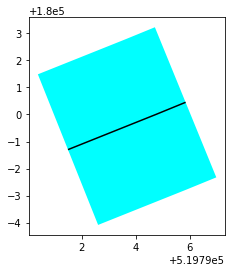

In [71]:
rs_ls = rs_ls.set_geometry('rsBuffGeometry')
base = rs_ls.query("TOID == '1000001778708315'").plot(color = 'cyan')

rs_ls = rs_ls.set_geometry('geometry')
rs_ls.query("TOID == '1000001778708315'").plot(ax = base, color = 'black')

In [72]:
#length of linestring
rs_ls = rs_ls.set_geometry('geometry')
rs_ls.query("TOID == '1000001778708315'").length

1    4.688844
dtype: float64

In [73]:
#perimiter of buffered shape
rs_ls = rs_ls.set_geometry('rsBuffGeometry')
rs_ls.query("TOID == '1000001778708315'").length

1    21.377687
dtype: float64

## Drop edges less than 2m long

I suppose technically some cars could fit through this. But a parking space is 2.4m wide, and 2m is pretty narrow, assuming you're fond of your wing mirrors.

In [74]:
rs_ls.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [75]:
rs_ls.shape

(1413, 8)

In [76]:
rs_ls[rs_ls.LineString_length.gt(2)].shape

(1329, 8)

In [110]:
print("Dropping roadside edges less than or equal to 2m in length removes"
      , rs_ls.shape[0] - rs_ls[rs_ls.LineString_length.gt(2)].shape[0]
     , "gardens from the dataframe")

Dropping roadside edges less than or equal to 2m in length removes 84 gardens from the dataframe


#### Cuts the annoying shared side alleys

(180250, 180300)

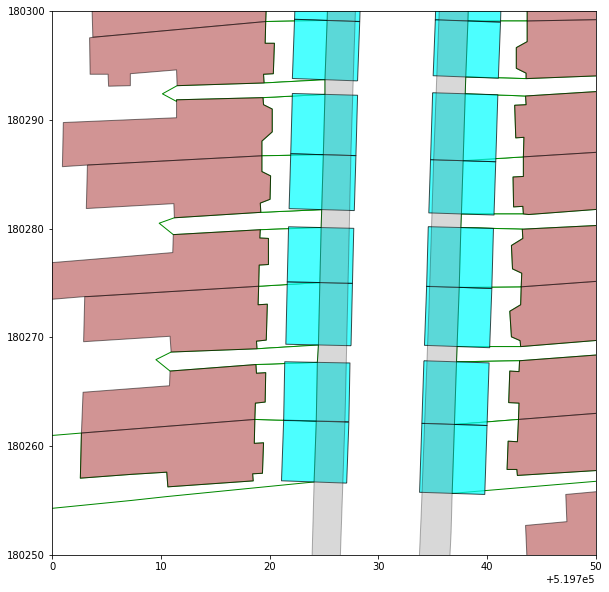

In [78]:
#plot linestrings greater than 2m long
base = gdn.plot(figsize = (10,10), color = 'white', edgecolor = '#008800')

rs_ls = rs_ls.set_geometry('rsBuffGeometry')
rs_ls[rs_ls.LineString_length.gt(2)].plot(ax = base, color = 'cyan', alpha = 0.7, edgecolor = 'black')

#add buildings
rd.plot(ax = base, color = 'brown', alpha = 0.5, edgecolor = 'black')
#add roadside original polygons
rs.plot(ax = base, color = 'grey', alpha = 0.3, edgecolor = 'black')

base.set_xlim(xmin = 519700, xmax = 519750)
base.set_ylim(ymin = 180250, ymax = 180300)

(180000, 180400)

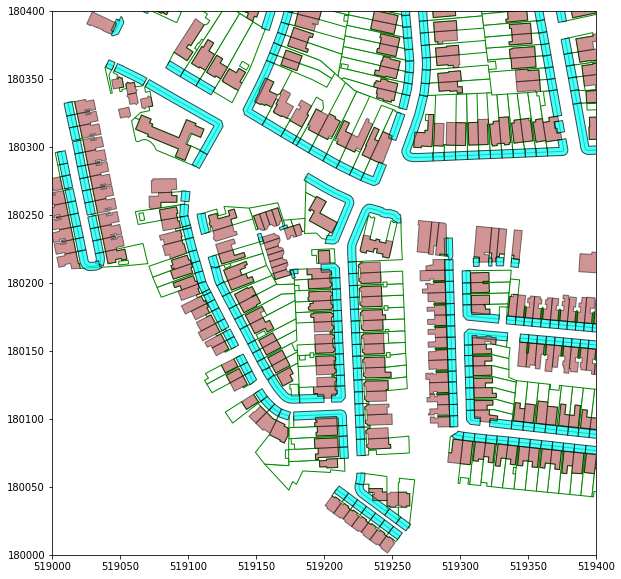

In [79]:
base = gdn.plot(figsize = (10,10), color = 'white', edgecolor = '#008800')

rs_ls = rs_ls.set_geometry('rsBuffGeometry')
rs_ls[rs_ls.LineString_length.gt(2)].plot(ax = base, color = 'cyan', alpha = 0.7, edgecolor = 'black')

rd.plot(ax = base, color = 'brown', alpha = 0.5, edgecolor = 'black')

base.set_xlim(xmin = 519000, xmax = 519400)
base.set_ylim(ymin = 180000, ymax = 180400)

## Write linestring geometry to file

In [80]:
rs_ls.shape

(1413, 8)

In [82]:
rs_ls.columns

Index(['TOID', 'DescriptiveGroup', 'SHAPE_Length', 'SHAPE_Area', 'rsTOID',
       'geometry', 'rsBuffGeometry', 'LineString_length'],
      dtype='object')

In [84]:
roadside_linestrings = (
    rs_ls[['TOID', 'rsTOID', 'geometry']]
    .rename({'TOID':'gdnTOID'}, axis = 'columns')
    .reset_index(drop = True)
)

In [85]:
roadside_linestrings.head()

,gdnTOID,rsTOID,geometry
0,1000001778708314,1000001778708368,"LINESTRING (519791.500 179998.700, 519790.100 ..."
1,1000001778708315,1000001778708368,"LINESTRING (519795.850 180000.450, 519794.750 ..."
2,1000001778708617,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ..."
3,1000001778708317,1000001778708368,"LINESTRING (519800.450 180005.450, 519801.550 ..."
4,1000001778708000,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ..."


In [86]:
roadside_linestrings.dtypes

gdnTOID       object
rsTOID        object
geometry    geometry
dtype: object

In [87]:
#write to csv
#here the TOIDs are object type, so the leading zeroes are preserved
#they may not show when opening in excel though - cos excel is trying to be helpful
#when pandas reads them back in the leading zeroes should be there, check 0001000003513170
roadside_linestrings.to_csv('../data/roadside_linestrings.csv', index=False)

## Crop gardens at 9m from roadside edge - create rs_buff

9m may cut some front gardens short of the building they are attached too. However, the reason for doing this is to cut off the rear extent of a garden where it is attached to the front garden by a side alley. We only need to detect a driveway to infer that a car may fit onto the property to park there. Hence we look for a manmade surface that intersects with the roadside that is large enough to accommodate a car (a rectangle of size 2.4m * 4.8m ). When we use overlay we must do it on gdfs of single rows so that each garden is compared only to the buffered roadside that it is paired with. If we don't do this we risk overlaps with other gardens that are to either side. The buffer needs to be rounded on the caps to account for gardens being less than perpendicular to their roadside edge. Tried first with 6m, but a few gardens are very much not perpendicular to the roadside, so increased to 9m.

- keep LineStrings greater than 2m in length
- create column of Xm buffer around roadside LineStrings, use cap_style = 1 (rounded), to account for property being less than perpendicular to the roadside. (frequently everthing is always off by about 5 degrees. fkw.)
- use overlay on gdf of gardens and gdf of buffered roadside edges
- keep garden and building toids as reference, and/or INSPIRE id (property extent), together with new polygon

In [88]:
#make copy and subset 
rs_buff = rs_ls.copy(deep = True)
#set geometry
rs_buff = rs_buff.set_geometry('geometry')
#keep only those over 2m
rs_buff = rs_buff[rs_buff.LineString_length.gt(2)]
#keep only linestring geometry
rs_buff = rs_buff[['TOID', 'geometry']]
#TOID, is front garden TOID
#geometry is the linestring geom of the roadside edge of the garden

#create Xm buff
rs_buff['rsBuffGeom'] = rs_buff.geometry.buffer(distance = 9, cap_style = 1, join_style = 1)
#drop linestring geom
rs_buff = rs_buff[['TOID', 'rsBuffGeom']]
#set geom
rs_buff = rs_buff.set_geometry('rsBuffGeom', crs = "EPSG:27700")

#sort values by TOID and reset index
rs_buff = rs_buff.sort_values(by = 'TOID').reset_index(drop = True)

rs_buff.head()

,TOID,rsBuffGeom
0,0001000003513170,"POLYGON ((519327.199 180206.627, 519326.659 18..."
1,1000001778258479,"POLYGON ((519688.572 180953.313, 519687.694 18..."
2,1000001778258579,"POLYGON ((519670.463 180950.420, 519669.586 18..."
3,1000001778258580,"POLYGON ((519697.333 180954.715, 519696.455 18..."
4,1000001778258608,"POLYGON ((519715.797 180957.667, 519714.920 18..."


In [89]:
rs_buff.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [90]:
rs_buff.shape

(1329, 2)

In [91]:
rs_buff.nunique()

TOID          1329
rsBuffGeom    1329
dtype: int64

(180000, 180400)

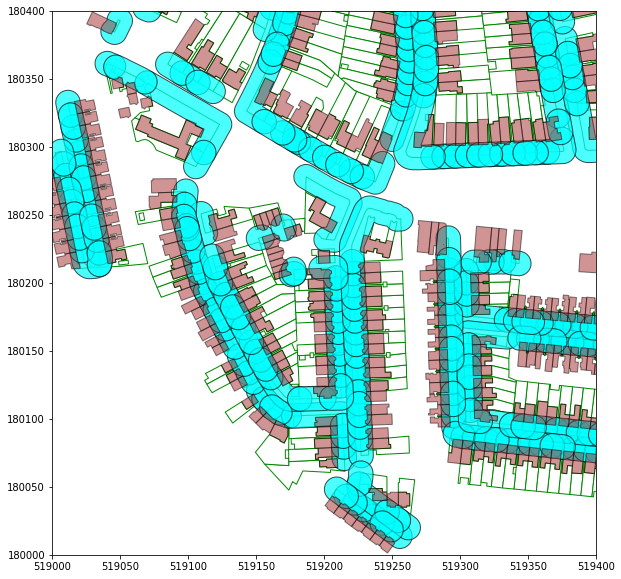

In [92]:
base = gdn.plot(figsize = (10,10), color = 'white', edgecolor = '#008800')

rs_buff.plot(ax = base, color = 'cyan', alpha = 0.7, edgecolor = 'black')

rd.plot(ax = base, color = 'brown', alpha = 0.5, edgecolor = 'black')

base.set_xlim(xmin = 519000, xmax = 519400)
base.set_ylim(ymin = 180000, ymax = 180400)

## Collect garden geoms assiociated with rs_buff

In [93]:
gdn_list = rs_buff['TOID'].drop_duplicates().tolist()
len(gdn_list)

1329

In [94]:
rs_buff_gdn = (
    gdn[gdn['TOID']
    .isin(gdn_list)]
    [['TOID', 'geometry']]
    .sort_values(by = 'TOID')
    .drop_duplicates()
    .reset_index(drop = True)
    
)

In [95]:
rs_buff_gdn.columns

Index(['TOID', 'geometry'], dtype='object')

In [96]:
rs_buff_gdn.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [97]:
rs_buff_gdn.head()

,TOID,geometry
0,0001000003513170,"POLYGON ((519327.150 180219.550, 519329.100 18..."
1,1000001778258479,"POLYGON ((519687.150 180962.200, 519684.727 18..."
2,1000001778258579,"POLYGON ((519669.000 180959.300, 519666.250 18..."
3,1000001778258580,"POLYGON ((519692.600 180982.100, 519695.050 18..."
4,1000001778258608,"POLYGON ((519715.400 180998.800, 519708.700 18..."


In [98]:
rs_buff_gdn.nunique()

TOID        1329
geometry    1329
dtype: int64

## Apply overlay to one row gdfs
This is safer than trying to do a whole gdf against another gdf.

Create 2 separate gdf with a one-one ID column, ordered by TOID, no duplicates. For each pair 
- create single row gdfs
- overlay to get intersection of geometries; the garden shaped cropped at 6m buffer from roadside. Only ever comparing one garden with its roadside buffered edge so no danger of collecting space from other gardens if the buffer is too big.
- append this to a df
- return df of new geometries and garden TOID ID.

- gdfs are rs_buff and rs_buff_gdn

In [99]:
#check same length
rs_buff.shape[0] == rs_buff_gdn.shape[0]

True

In [100]:
#check TOID ordering is the same
#indexes have been reset so are also equal
( rs_buff[['TOID']] == rs_buff_gdn[['TOID']] ).sum()

TOID    1329
dtype: int64

#TRY lambda method
#use lambda to apply a function to each row of a gdf
rs_ls['geometry'] = ( 
    rs_ls['geometry'].apply(lambda x: linemerge(x) if x.geom_type == 'MultiLineString' else x)
)


In [101]:
#this takes about 30 s econds to run!
#create list to hold the results
cropped_gardens = []

#rs_buff and rs_buff_gdn have the same length
for i in np.arange(rs_buff.shape[0]):
    
    #create single row gdf of rs_buff
    gdf1 = rs_buff.iloc[i:i+1]
    #create single row gdf of rs_buff_gdn
    gdf2 = rs_buff_gdn.iloc[i:i+1]
    
    #overlay two single row gdfs
    g = gpd.overlay(gdf1, gdf2, how = 'intersection', keep_geom_type=True)
    
    #store overlay resulting gf in list
    cropped_gardens.append(g);

#use pd.concat to combine gdfs in list to a single gdf
#reset index since every row has index 0
cropped_gardens = pd.concat(cropped_gardens).reset_index(drop=True)

In [102]:
cropped_gardens.head()
#TOID_1 and TOID_2 are both the garden TOID

,TOID_1,TOID_2,geometry
0,0001000003513170,0001000003513170,"POLYGON ((519327.150 180219.550, 519329.100 18..."
1,1000001778258479,1000001778258479,"POLYGON ((519684.949 180970.923, 519685.728 18..."
2,1000001778258579,1000001778258579,"POLYGON ((519666.761 180968.013, 519667.537 18..."
3,1000001778258580,1000001778258580,"POLYGON ((519693.713 180972.325, 519694.467 18..."
4,1000001778258608,1000001778258608,"POLYGON ((519712.133 180975.268, 519712.903 18..."


In [103]:
cropped_gardens.shape

(1329, 3)

In [104]:
cropped_gardens.dtypes

TOID_1        object
TOID_2        object
geometry    geometry
dtype: object

In [105]:
cropped_gardens.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

### Compare cropped gardens to roadside buffer and gardens

(180000, 180400)

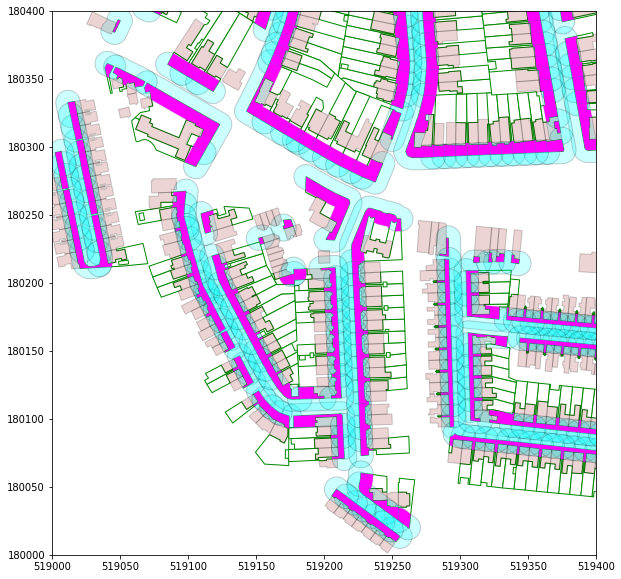

In [106]:
base = rs_buff_gdn.plot(figsize = (10,10), color = 'white', edgecolor = '#008800')

rs_buff.plot(ax = base, color = 'cyan', alpha = 0.2, edgecolor = 'black')

rd.plot(ax = base, color = 'brown', alpha = 0.2, edgecolor = 'black')

cropped_gardens.plot(ax = base, color = 'magenta')

base.set_xlim(xmin = 519000, xmax = 519400)
base.set_ylim(ymin = 180000, ymax = 180400)

### Save these shapes
Rename columns and save
TOID_1 & TOID_2 are both the garden TOID

In [107]:
cropped_gardens = (
    cropped_gardens.drop(['TOID_2'], axis=1)
    .rename({'TOID_1':'gdnTOID'}, axis = 'columns')
    .reset_index(drop = True)
)

In [392]:
#write to csv
#here the TOIDs are object type, so the leading zeroes are preserved
#they may not show when opening in excel though - cos excel is trying to be helpful
#when pandas reads them back in the leading zeroes should be there, check 0001000003513170
cropped_gardens.to_csv('../data/cropped_gardens.csv', index=False)

In [108]:
cropped_gardens.head()

,gdnTOID,geometry
0,0001000003513170,"POLYGON ((519327.150 180219.550, 519329.100 18..."
1,1000001778258479,"POLYGON ((519684.949 180970.923, 519685.728 18..."
2,1000001778258579,"POLYGON ((519666.761 180968.013, 519667.537 18..."
3,1000001778258580,"POLYGON ((519693.713 180972.325, 519694.467 18..."
4,1000001778258608,"POLYGON ((519712.133 180975.268, 519712.903 18..."


### Example pre/post-crop

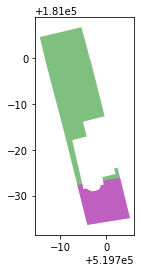

In [109]:
#garden pre-crop
base = gdn.query("TOID == '1000001778258580'").plot(color = 'green', alpha = 0.5)
#post-crop
cropped_gardens.query("gdnTOID == '1000001778258580'").plot(ax = base, color = 'magenta', alpha = 0.5)

## Create new example for report

TOID 1000001778697829 to match segmentation example

In [3]:
#cg: cropped gardens
#read in as strings
cg = pd.read_csv("../data/cropped_gardens.csv"
                 , dtype={'gdnTOID': object, 'geometry': object})
#convert WKT strings to geometry
cg['geometry'] = cg['geometry'].map(shp.wkt.loads)
#convert to geodataframe and set CRS
cg = gpd.GeoDataFrame(cg, crs="EPSG:27700", geometry="geometry")

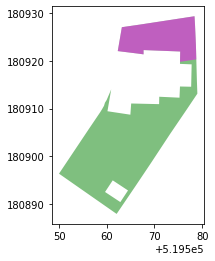

In [18]:
#garden pre-crop
base = gdn.query("TOID == '1000001778697829'").plot(color = 'green', alpha = 0.5)
#post-crop
cg.query("gdnTOID == '1000001778697829'").plot(ax = base, color = 'magenta', alpha = 0.5)

## Next

 - use the cropped garden geometry to cut out polygons from AP RGBI
 - ... image processing

# ARCHIVE

## Load Near Infra Red Aerial Photography TQ1980

See ppp03 for full details

In [ ]:
#get path for TQ1980 AP RGBI
rgbiTQ1980 = '../data/APGB_Ealing_InfraRedImagery/111803_20200707/50cm Colour Infrared/111803-1_CIR_1_Shape/TQ1980.tif'


In [ ]:
src = rasterio.open(rgbiTQ1980)
print("path: ", src.name, "\nmode: ", src.mode, "\nis closed?: ", src.closed
      , "\nband count: ", src.count, "\nshape: ", src.shape)

In [ ]:
#make sure 'from rasterio import plot' is run ffs
plot.show(src)

## Create gdf of just roadside polygons with buffer

In [ ]:
rs_buff = gdn_toid_per_rs_poly.copy(deep = True)
rs_buff = rs_buff.set_geometry('rsBuffGeometry')
rs_buff = (
    rs_buff.drop(['rsGeometry'], axis = 1)
    .rename({'TOID_left':'rsFirstTOID'}, axis = 1)
)

rs_buff.head()

In [ ]:
rs_buff.shape

## Collect overlay intersection between gdn and buffered rs polygons
Use geopandas overlay function, geopandas.overlay(df1, df2, how='intersection'), but give the pavement a tiny buffer first, because 'overlay' does not count adjacent edges as intersecting!!! 

Default is to return the same geometry type - if you want to return linestring from polygon then set this to False - then it will recognise adjacency as intersecting

See archive section for demo

In [ ]:
rs_buff.geometry.name

In [ ]:
#I think this check everything against everything - computationally expensive
gdn_int_rs_buff = gpd.overlay(gdn, rs_buff, how = 'intersection')

In [ ]:
gdn_int_rs_buff.head()

In [ ]:
base = gdn.query("TOID == '0001000003513170'").plot(color = 'green', alpha = 0.5)
rs_buff.query("gdnTOID == '1000001778713631'").plot(ax = base, color = 'grey', alpha = 0.2)
gdn_int_rs_buff.query("index == 0").plot(ax = base, color = 'magenta')
gdn.query("TOID == '1000001778713631'").plot(ax = base)
#well that has now worked as exepected...WTF?
#but why do my TOIDs and gdnTOIDs not match? something very odd here

## Clearly something has gone very wrong...

Test single row gdfs

In [ ]:
gdf1 = gdn.query("TOID == '1000001778707982'")
gdf2 = rs_buff.query("rsFirstTOID == '1000001778783951'")

gdf3 = gpd.overlay(gdf1, gdf2, how = 'intersection')

In [ ]:
base = gdf2.plot(color = 'grey')
gdf1.plot(ax = base, color = 'green')
gdf3.plot(ax = base, color = 'magenta')

#this is as expected

## Add buffer to merged roadside polygons

In [ ]:
#take the grouped/dissolved polygons from  gdn_toid_per_rs_poly and add 
#geometry with a buffer, 50cm - 1 pixel in AP RGBI
gdn_toid_per_rs_poly['rsBuffGeometry'] = gdn_toid_per_rs_poly.rsGeometry.buffer(distance = 0.25)

In [ ]:
gdn_toid_per_rs_poly.geometry.name

In [ ]:
gdn_toid_per_rs_poly = gdn_toid_per_rs_poly.set_geometry('rsBuffGeometry')
base = gdn_toid_per_rs_poly.plot(figsize = (10,10), color = 'black')
gdn_toid_per_rs_poly = gdn_toid_per_rs_poly.set_geometry('rsGeometry')
gdn_toid_per_rs_poly.plot(ax = base, color = 'grey')
base.set_xlim(xmin = 519650, xmax = 519700)
base.set_ylim(ymin = 180500, ymax = 180550)

In [ ]:
gdn_toid_per_rs_poly.head()

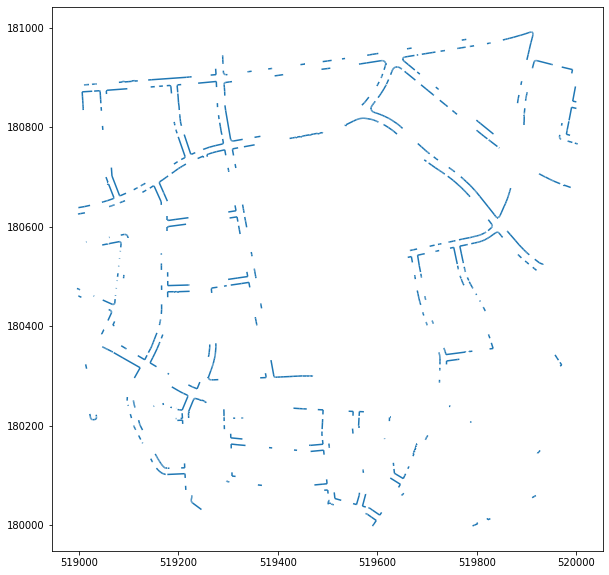

In [50]:
(
    rsEdge[rsEdge['geometry']
           .geom_type == 'MultiLineString']
    .reset_index(drop = True)
  #  .query("index < 2")
    .plot(figsize = (10,10)))

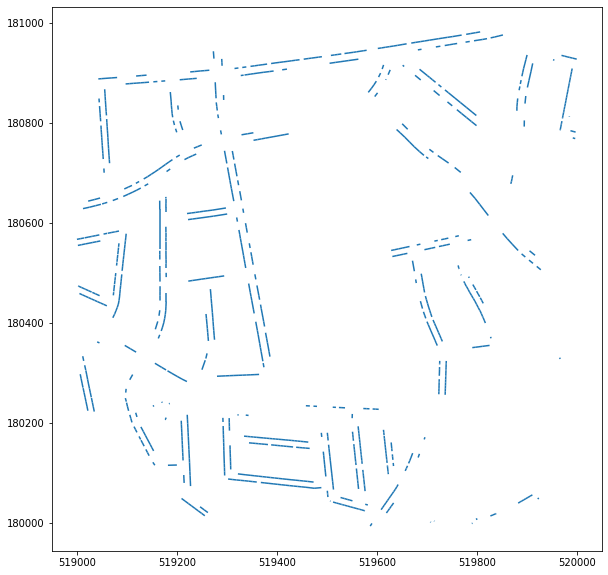

In [54]:
(
    rsEdge[rsEdge['geometry']
           .geom_type == 'LineString']
    .reset_index(drop = True)
#    .query("index < 6")
    .plot(figsize = (10,10)))

In [51]:
#inspect multilinestring
rsEdge.iloc[1]

TOID                                                 1000001778708315
DescriptiveGroup                                      General Surface
SHAPE_Length                                                  15.4276
SHAPE_Area                                                     13.905
rsTOID                                               1000001778708368
geometry            (LINESTRING (519795.8499999996 180000.44999999...
Name: 1, dtype: object

In [ ]:
#Seaborn palettes only have 10 colours, so join them together to create a bigger palette
#deep, muted, bright, pastel, dark, colorblind
c20 = (sns.color_palette(palette = 'bright', n_colors = 10) 
       + sns.color_palette(palette = 'colorblind', n_colors = 10, desat=0.9) ) 

n_ships = pfv1224_top['mmsi'].nunique()
obs = pfv1224_top['mmsi'].tolist() #order of mmsis in pfv1224 to apply color to in same order for plotting
c_list = c20[0:n_ships] #choose top n_ships colours from combined palettes
label_list = pfv1224_top['mmsi'].unique() #list the unique mmsis in pfv1224
c_dict = dict(zip(label_list, c_list)) #create dict of zipped lists
label_color = [c_dict[s] for s in obs] #apply c_dict to the labels for each point

pfv1224_top = pfv1224_top.set_geometry('geom_cen_buff') #set geometry to the buffer circles
base = pfv1224_top.plot(alpha = 0.3, figsize=(10,10), color = label_color ) 
base.set_xlim(-11000000, -8500000)
base.set_ylim(-2000000, 2000000)
pfv1224_top = pfv1224_top.set_geometry('geom_centroid') #set geometry to points
pfv1224_top.plot(ax = base, color = label_color)
land.plot(ax = base, color = 'black', alpha = 0.3)
plt.grid(b=None)

## Group join_rs by gdn TOID and merge roadside polygons

# CHECK

Removed gardens that had more than one roadside polygon so no need to do this step. Also removed lots of other duplicate rows which may have contributed to the confusion of merging a roadside polygon with another instance of itself.

In [ ]:
#1 roadside geometry row per garden TOID
#drop useless columns TOID_left (the first row of the roadside TOID in the garden TOID group)
#and index_right, the gdn index
gdn_toid_per_rs_poly = (
    join_rs.dissolve(by = "TOID_right")
    .drop(['TOID_left', 'index_right'], axis=1)
    .reset_index()
    .rename({'TOID_right': 'gdnTOID', 'geometry':'rsGeometry'}, axis='columns')
    .set_geometry('rsGeometry')
)


In [ ]:
gdn_toid_per_rs_poly.shape
#yay, now have one roadside polygon per garden toid
#the TOID_left is now meaningless as the dissolve function by default keeps the first row
#when aggregating

In [ ]:
gdn_toid_per_rs_poly.head()

## Check merged roadside shapes are adjacent to gardens

In [ ]:
base = gdn_toid_per_rs_poly.query("index == 0").plot(color = 'grey')
ta.query("TOID == '0001000003513170'").plot(ax = base, color = 'green')

## Now roadside polygons overlap
The bolder shapes are such because they have been plotted over more than once - a roadside polygon will be plotted for each garden it instersects. Merged some roadside polygons in case a garden shape overlapped with more than one separate poly, only want one row. It was only a few that had more than one rs poly per gdn.

In [ ]:
gdn_toid_per_rs_poly.plot(figsize=(10,10), color = 'magenta', alpha = 0.2)
#now I have overlapping geometries, where I have joined more than one roadside geometry together
#if they intersect with a single garden geometry

In [ ]:
gdn_toid_per_rs_poly.head()

In [ ]:
p1 = shp.geometry.Polygon(shell = [[0,0],[0,1],[1,1],[1,0]]
                     , holes = [[[0.75, 0.75],[0.25, 0.25],[0.25, 0.75],[0.75, 0.75]]])

p1

In [ ]:
p2 = shp.geometry.Polygon(((0.5,0.5),(1.5,0.5),(1.5,1.5),(0.5,1.5),(0.5,0.5)))
p2

In [ ]:
p3 = shp.geometry.Polygon(((1.5,0.5),(2.5,1.5),(1.5,1.5),(1.5,0.5)))
p3

In [ ]:
df1 = pd.DataFrame(
{'geometry':[p1]}
)
gdf1 = gpd.GeoDataFrame(df1)

df2 = pd.DataFrame(
{'geometry':[p2]}
)
gdf2 = gpd.GeoDataFrame(df2)

df3 = pd.DataFrame(
{'geometry':[p3]}
)
gdf3 = gpd.GeoDataFrame(df3)

In [ ]:
inter1 = gpd.overlay(gdf1, gdf2, how = 'intersection')

In [ ]:
base = inter1.plot()
gdf1.plot(ax = base, color = 'magenta', alpha = 0.2)
gdf2.plot(ax = base, color = 'green', alpha = 0.2)

In [ ]:
inter2 = gpd.overlay(gdf3, gdf2, how = 'intersection')
base = inter2.plot()
gdf3.plot(ax = base, color = 'magenta', alpha = 0.2)
gdf2.plot(ax = base, color = 'green', alpha = 0.2)
#bugger overlay does not count adjacent lines!!!!

## Load Topographic Line TQ1980

I created this in QGIS by selecting all the polygons in the TL layer that intersected with the TQ1980 raster layer, by drawing a square around it. NB the Topographic Line layer is just linestrings, **none of them close up to make the boundary of a polygon**.

**tl contains only linestrings, does not contain the RoadSide label in TopographicArea. So cannot use it.**

In [ ]:
path = "../data/eTopoLine_1980/eTopoLine_1980.gpkg"
for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
        
tl = gpd.read_file(path)

In [ ]:
tl.plot(figsize=(10,10), linewidth = 1)

In [ ]:
tl.DescriptiveGroup.value_counts()
#does not include roadside. So I think the linestrings here the 

In [ ]:
tl.DescriptiveTerm.value_counts()


### Filter for just roadside linestrings

In [ ]:
#create gdf of roadside objects tl_rs (topographic line roadside)
tl_rs = tl.query('DescriptiveGroup == "Road Or Track"')
tl_rs.plot(figsize = (10,10), color = 'grey')

## Overlay ta and tl

tl contains only linestrings, does not contain the RoadSide label in TopographicArea. So cannot use it.

In [ ]:
base = ta.plot(figsize=(10,10), color = 'green')
tl.plot(ax = base, color = 'black', linewidth = 1)
tl_rs.plot(ax = base, color = 'magenta', linewidth = 1)
tl.query("DescriptiveTerm == 'Inferred Property Closing Link'").plot(ax = base)
base.set_xlim(xmin = 519600, xmax = 519800)
base.set_ylim(ymin = 180500, ymax = 180750)

In [ ]:
tl.query("DescriptiveTerm == 'Inferred Property Closing Link'").plot()

## gdn needs dissolving


In [ ]:
v = gdn.TOID.value_counts() #create value counts of specified column values
gdn[gdn.TOID.isin(v.index[v.gt(1)])].sort_values(by  = 'TOID') #use v to subset for greater than (gt) n. (less than: lt)